In [1]:
%matplotlib inline

import pandas as pd
import scipy as sp
from scipy.optimize import fmin_slsqp
import numpy as np
from IPython.core.debugger import set_trace
from tqdm import tqdm_notebook

# 초기화

In [2]:
xl = 'data_20191231.xlsx'

In [3]:
univ = pd.read_excel(xl, sheet_name='category'); univ;

In [4]:
regions = univ.region.unique(); regions

array(['BM', 'US', 'Global', 'EM', 'DM', 'UST'], dtype=object)

In [5]:
cats = univ.category.unique(); cats

array(['BM', 'US_HD', 'US_HD_LV', 'US_DG', 'US_DG_QL', 'US_PS', 'Global',
       'EM', 'DM', 'UST'], dtype=object)

In [6]:
prices = pd.read_excel(xl, sheet_name='price', index_col=0)
rtns = np.log(prices).diff(); rtns;

In [7]:
dvds = pd.read_excel(xl, sheet_name='dvd', index_col=0); dvds;

In [8]:
prices_bm = pd.read_excel(xl, sheet_name='bm', index_col=0)
rtns_bm = np.log(prices_bm).diff(); rtns_bm;

# 초기전략: 최적화만 하는 경우

In [9]:
'''
변수설정
'''
n_dates = len(rtns)
n_cov = 12             # cov 계산 개월수

bm_w_max = 0.30
w_max = 0.10           # 종목 최대비중
w_us_min = 0.4         # 미국 최소비중
w_us_max = 0.8         # 미국 최대비중
w_ps_max = 0.1         # 우선주 최대비중
dvd_min = 3          # 포트폴리오 최소 배당수익률
te_limit_max = 0.05
te_limit_min = 0.01

n = len(rtns.columns)  # 종목수
dates_rng = range(n_cov, n_dates)
weights = np.zeros((len(dates_rng), n))
result = {}


def covar(rt):
    _cov = rt.cov(min_periods=n_cov/2)
    _exc = _cov.iloc[0].isna()
    return _cov.fillna(0), _exc


for i in tqdm_notebook(dates_rng[:]):
    date = rtns.index[i]
    
    _rtns = rtns.iloc[i-11:i+1]
    cov, exc = covar(_rtns)
    dvd = dvds.iloc[i]
    
    investable = 1 - (dvd.isna() | _rtns.iloc[-1].isna() | exc)
    investable.iloc[-2:] = 0
    
    w_p0 = (1/_rtns.std()) * investable
    w_p0 = w_p0.fillna(0) / w_p0.sum()

    _w_max = w_max*investable
    #_w_max = w_p0*3
    #_w_max[_w_max>w_max] = w_max
    _w_max.iloc[0] = bm_w_max
    bounds = list(zip(np.zeros(n), _w_max)) 
    

    def obj1(w_p):
        #return vol(w_p)
        return -sharpe(w_p)
        #return -ir(w_p)
        #return -rtn_projection(w_p)
    
    def obj2(w_p):
        return vol(w_p)
        #return -rtn_projection(w_p)
    
    
    def sharpe(w_p):
        _rp = rtn_projection(w_p)
        _vol = vol(w_p)
        return _rp / _vol

    def ir(w_p):
        _rp = rtn_projection(w_p, rel=True)
        _te = te(w_p)
        return _rp / _te
    
    
    def rtn_projection(w_p, rel=False):
        _rtns_sum = _rtns.iloc[:-1].sum().fillna(0)
        _proj = _rtns_sum @ w_p
        
        if rel:
            return _proj - _rtns_sum[0]
        else:
            return _proj
        
    
    def vol(w_p, te=False):
        ww = w_p.copy()
        if te: ww[0] -= 1
        var = 12 * (ww @ cov @ ww)
        return var**0.5
        
        
    def te(w_p):
        return vol(w_p, te=True)

    def te_max(w_p):
        return te_limit_max - te(w_p)
    
    def te_min(w_p):
        return te(w_p) - te_limit_min
    
#     def rp_err_max(w_p):
#         return 0.03 - (w_p0[1:]/w_p0[1:].sum() - w_p[1:]/w_p[1:].sum()).std()
        
#     def rp_corr(w_p):
#         return np.corrcoef(w_p0[1:-2], w_p[1:-2])[0,1]# - 0.1
        
    
    def sum_to_one(w_p):
        return 1 - w_p.sum()
    
    # 미국 최소비중
    def us_min(w_p):
        return w_p[0]/2 + w_p[1:25].sum() - w_us_min

    # 미국 최대비중
    def us_max(w_p):
        return w_us_max - w_p[0]/2 - w_p[1:25].sum()
    
    # 우선주 최대비중
    def ps_max(w_p):
        return w_ps_max - w_p[20:25].sum()

    
    def port_dvd(w_p):
        return dvd.fillna(0) @ w_p
    
    
    # 포트폴리오 최소 배당수익률
    def dvd_sum_min(w_p):
        return port_dvd(w_p) - dvd_min

    opt = {
        'eqcons': [sum_to_one], 
        'ieqcons': [ us_min, us_max, ps_max, dvd_sum_min, te_max, te_min ], 
        'bounds': bounds,
        'iter': 1000, 
        'full_output': True, 
        'iprint': 0
    }
    
    resp1 = fmin_slsqp(obj1, w_p0, **opt)
    resp2 = fmin_slsqp(obj2, w_p0, **opt)

    
    if (resp1[3]==0) and (resp2[3]==0):
        pos = resp1[0]*0.9 + resp2[0]*0.1
        
    else:
        pos = w_p0
        print(date, resp1[-1], resp2[-1])

        
#     if (resp1[3]==0):
#         pos = resp1[0]
        
#     else:
#         pos = w_p0
#         print(date, resp1[-1])
        
        
    weights[i-n_cov,:] = pos
    result[date] = {
        #'sharpe': -resp[1], 
        'w_total': pos.sum(),
        'dvd': port_dvd(pos), 
        'te': te(pos), 
    }

In [10]:
df_result = pd.DataFrame(result).T; df_result

,dvd,te,w_total
2010-12-31,3.211137,0.049782,1.0
2011-01-31,3.119710,0.049545,1.0
2011-02-28,3.082361,0.049783,1.0
2011-03-31,3.154880,0.049900,1.0
2011-04-29,3.000000,0.049697,1.0
2011-05-31,3.246376,0.049749,1.0
2011-06-30,3.332458,0.049911,1.0
2011-07-29,3.470890,0.049931,1.0
2011-08-31,3.021582,0.049928,1.0
2011-09-30,3.615513,0.049904,1.0


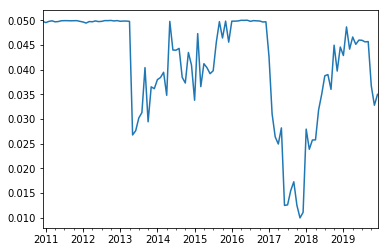

In [11]:
df_result.te.plot()

In [12]:
df_w = pd.DataFrame(weights, index=df_result.index, columns=dvds.columns).shift(1); df_w;

In [13]:
df_w.iloc[-1][df_w.iloc[-1]>0.000001].round(4)

ACWI    0.1029
HDV     0.0079
FVD     0.1000
DIV     0.0100
VIG     0.1000
NOBL    0.0958
DGRO    0.0900
PGX     0.0900
PGF     0.0100
PID     0.0900
VYMI    0.0100
DEM     0.1000
DGS     0.0963
DVYE    0.0100
IDV     0.0871
Name: 2019-12-31 00:00:00, dtype: float64

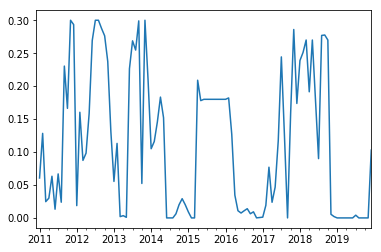

In [14]:
df_w.ACWI.plot()

In [15]:
df_rtns = rtns.loc[df_result.index, dvds.columns]; df_rtns;

In [16]:
cum_port0 = (df_w*df_rtns).sum(axis=1).cumsum(); cum_port0;

In [17]:
cum_bm = rtns_bm.loc[df_result.index]['ACWI TR']
cum_bm.iloc[0] = 0
cum_bm = cum_bm.cumsum(); cum_bm;

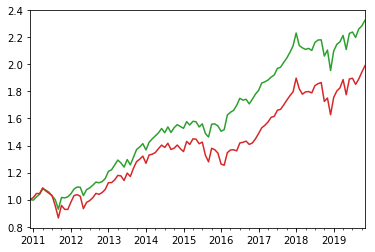

In [18]:
cum = np.exp(pd.DataFrame({'port_0':cum_port0, 'bm':cum_bm})).iloc[:-1]
cum.plot(color=['tab:green','tab:red'], legend=None)

In [19]:
std = cum.pct_change().std()*(12**0.5) * 100
cagr = (cum.iloc[-1]**(12/(len(cum)-1))-1) * 100
rar = cagr/std
stats = pd.DataFrame({'cagr':cagr, 'std':std, 'rar':rar})
stats['cagr_ex'] = stats.cagr - stats.cagr['bm']
stats['te'] = cum.pct_change().sub(cum.bm.pct_change(), axis=0).std()*(12**0.5) * 100
stats['ir'] = (stats.cagr_ex/stats.te).fillna(0)
stats.round(2)

,cagr,std,rar,cagr_ex,te,ir
port_0,9.93,9.88,1.01,1.91,4.3,0.44
bm,8.03,12.27,0.65,0.00,0.0,0.00


# 모멘텀 종목 고르는 경우

In [20]:
'''
변수설정
'''
n_dates = len(rtns)
n_cov = 12             # cov 계산 개월수

bm_w_max = 0.30
w_max = 0.10           # 종목 최대비중
w_us_min = 0.4         # 미국 최소비중
w_us_max = 0.8         # 미국 최대비중
w_ps_max = 0.1         # 우선주 최대비중
dvd_min = 3          # 포트폴리오 최소 배당수익률
te_limit_max = 0.05
te_limit_min = 0.01

n = len(rtns.columns)  # 종목수
dates_rng = range(n_cov, n_dates)
weights = np.zeros((len(dates_rng), n))
result = {}


def covar(rt):
    _cov = rt.cov(min_periods=n_cov/2)
    _exc = _cov.iloc[0].isna()
    return _cov.fillna(0), _exc


def has_value(rt, n_filter, investable):
    vals = (-rt.iloc[-1] / rt.iloc[-12:].sum(min_count=10)).values
    #vals = rt.iloc[-3:].sum(min_count=3).values
    vals[investable.values==0][:] = np.nan
    vals[-2:] = np.nan
    univ['value'] = vals
    out = univ.groupby('category')['value'].rank(ascending=False, pct=True, na_option='bottom') <= n_filter
    out[0] = 1
    return out


for i in tqdm_notebook(dates_rng[:]):
    date = rtns.index[i]
    
    _rtns = rtns.iloc[i-11:i+1]
    cov, exc = covar(_rtns)
    dvd = dvds.iloc[i]
    
    investable = 1 - (dvd.isna() | _rtns.iloc[-1].isna() | exc)
    #investable = investable.values * has_value(_rtns, 0.5, investable)
    #investable = has_value(_rtns, 0.5, investable)
    investable.iloc[0] = 1
    investable.iloc[-2:] = 0
    
    w_p0 = (1/_rtns.std()) * investable.values
    w_p0 = w_p0.fillna(0) / w_p0.sum()

    valuable = has_value(_rtns, 0.5, investable)
    
    _w_max = w_max*investable
    _w_max[valuable.values] = _w_max * 1.2
    _w_max[~valuable.values] = _w_max * 0#.5    
    _w_max.iloc[0] = bm_w_max
    bounds = list(zip(np.zeros(n), _w_max))
    

    def obj1(w_p):
        #return vol(w_p)
        return -sharpe(w_p)
        #return -ir(w_p)
        #return -rtn_projection(w_p)
    
    def obj2(w_p):
        return vol(w_p)
        #return -rtn_projection(w_p)
    
    
    def sharpe(w_p):
        _rp = rtn_projection(w_p)
        _vol = vol(w_p)
        return _rp / _vol

    def ir(w_p):
        _rp = rtn_projection(w_p, rel=True)
        _te = te(w_p)
        return _rp / _te
    
    
    def rtn_projection(w_p, rel=False):
        _rtns_sum = _rtns.iloc[:-1].sum().fillna(0)
        _proj = _rtns_sum @ w_p
        
        if rel:
            return _proj - _rtns_sum[0]
        else:
            return _proj
        
    
    def vol(w_p, te=False):
        ww = w_p.copy()
        if te: ww[0] -= 1
        var = 12 * (ww @ cov @ ww)
        return var**0.5
        
        
    def te(w_p):
        return vol(w_p, te=True)

    def te_max(w_p):
        return te_limit_max - te(w_p)
    
    def te_min(w_p):
        return te(w_p) - te_limit_min
    
#     def rp_err_max(w_p):
#         return 0.03 - (w_p0[1:]/w_p0[1:].sum() - w_p[1:]/w_p[1:].sum()).std()
        
#     def rp_corr(w_p):
#         return np.corrcoef(w_p0[1:-2], w_p[1:-2])[0,1]# - 0.1

        
    def sum_to_one(w_p):
        return 1 - w_p.sum()
    
    # 미국 최소비중
    def us_min(w_p):
        return w_p[0]/2 + w_p[1:25].sum() - w_us_min

    # 미국 최대비중
    def us_max(w_p):
        return w_us_max - w_p[0]/2 - w_p[1:25].sum()
    
    # 우선주 최대비중
    def ps_max(w_p):
        return w_ps_max - w_p[20:25].sum()

    
    def port_dvd(w_p):
        return dvd.fillna(0) @ w_p
    
    
    # 포트폴리오 최소 배당수익률
    def dvd_sum_min(w_p):
        return port_dvd(w_p) - dvd_min

    
    opt = {
        'eqcons': [sum_to_one], 
        'ieqcons': [ us_min, us_max, ps_max, dvd_sum_min, te_max, te_min ], 
        'bounds': bounds,
        'iter': 1000, 
        'full_output': True, 
        'iprint': 0
    }
    
    resp1 = fmin_slsqp(obj1, w_p0, **opt)
    resp2 = fmin_slsqp(obj2, w_p0, **opt)

    
    if (resp1[3]==0) and (resp2[3]==0):
        pos = resp1[0]*0.95 + resp2[0]*0.05
        
    else:
        pos = w_p0
        print(date, resp1[-1], resp2[-1])

        
#     if (resp1[3]==0):
#         pos = resp1[0]
        
#     else:
#         pos = w_p0
#         print(date, resp1[-1])
        
        
    weights[i-n_cov,:] = pos
    result[date] = {
        #'sharpe': -resp[1], 
        'w_total': pos.sum(),
        'dvd': port_dvd(pos), 
        'te': te(pos), 
    }

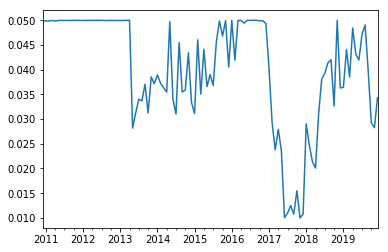

In [21]:
df_result = pd.DataFrame(result).T; df_result.te.plot()

In [22]:
df_w = pd.DataFrame(weights, index=df_result.index, columns=dvds.columns).shift(1)

In [23]:
df_w.round(4).iloc[-1][df_w.iloc[-1]>0.00001]

ACWI    0.294
HDV     0.006
FVD     0.120
VIG     0.120
SDY     0.120
PGX     0.095
PGF     0.005
DGS     0.120
IDV     0.120
Name: 2019-12-31 00:00:00, dtype: float64

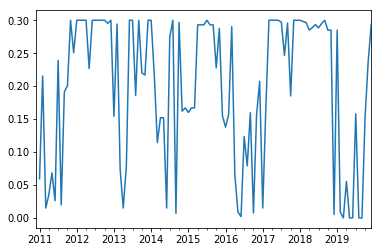

In [24]:
df_w.ACWI.plot()

In [25]:
df_rtns = rtns.loc[df_result.index, dvds.columns]

In [26]:
cum_port1 = (df_w*df_rtns).sum(axis=1).cumsum()

In [27]:
cum_bm = rtns_bm.loc[df_result.index]['ACWI TR']
cum_bm.iloc[0] = 0
cum_bm = cum_bm.cumsum(); cum_bm;

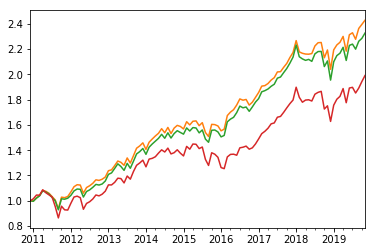

In [28]:
cum = np.exp(pd.DataFrame({'port_1':cum_port1, 'port_0':cum_port0, 'bm':cum_bm})).iloc[:-1]
cum.plot(color=['tab:orange','tab:green','tab:red'], legend=None)

In [29]:
std = cum.pct_change().std()*(12**0.5) * 100
cagr = (cum.iloc[-1]**(12/(len(cum)-1))-1) * 100
rar = cagr/std
stats = pd.DataFrame({'cagr':cagr, 'std':std, 'rar':rar})
stats['cagr_ex'] = stats.cagr - stats.cagr['bm']
stats['te'] = cum.pct_change().sub(cum.bm.pct_change(), axis=0).std()*(12**0.5) * 100
stats['ir'] = (stats.cagr_ex/stats.te).fillna(0)
stats.round(2)

,cagr,std,rar,cagr_ex,te,ir
port_1,10.46,9.96,1.05,2.43,4.15,0.59
port_0,9.93,9.88,1.01,1.91,4.30,0.44
bm,8.03,12.27,0.65,0.00,0.00,0.00


# BM 모멘텀이 안나올때 UST 편입하는 경우

In [30]:
df_bm_rtns = rtns['ACWI'].rolling(3).sum().loc[df_result.index]; df_bm_rtns;

In [31]:
UST = 'TLT'

In [32]:
df_w_append = df_w.copy()
for date, val in df_bm_rtns.items():
    if val<0:
        df_w_append.loc[date] *= 0.8
        df_w_append.loc[date, UST] = 0.2

In [33]:
#df_rtns[UST] = rtns.loc[df_result.index, UST]

In [34]:
cum_port2 = (df_w_append*df_rtns).sum(axis=1).cumsum()

In [35]:
cum_bm = rtns_bm.loc[df_result.index]['ACWI TR']
cum_bm.iloc[0] = 0
cum_bm = cum_bm.cumsum(); cum_bm;

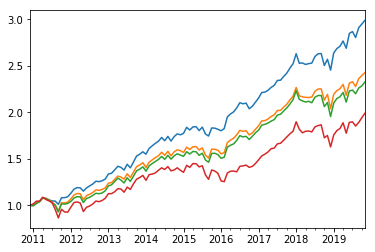

In [36]:
cum = np.exp(pd.DataFrame({'port_2':cum_port2, 'port_1':cum_port1, 'port_0':cum_port0, 'bm':cum_bm})).iloc[:-1]
cum.plot(color=['tab:blue','tab:orange','tab:green','tab:red'], legend=None)

In [37]:
std = cum.pct_change().std()*(12**0.5) * 100
cagr = (cum.iloc[-1]**(12/(len(cum)-1))-1) * 100
rar = cagr/std
stats = pd.DataFrame({'cagr':cagr, 'std':std, 'rar':rar})
stats['cagr_ex'] = stats.cagr - stats.cagr['bm']
stats['te'] = cum.pct_change().sub(cum.bm.pct_change(), axis=0).std()*(12**0.5) * 100
stats['ir'] = (stats.cagr_ex/stats.te).fillna(0)
stats.round(2)

,cagr,std,rar,cagr_ex,te,ir
port_2,13.07,8.37,1.56,5.04,5.89,0.86
port_1,10.46,9.96,1.05,2.43,4.15,0.59
port_0,9.93,9.88,1.01,1.91,4.30,0.44
bm,8.03,12.27,0.65,0.00,0.00,0.00


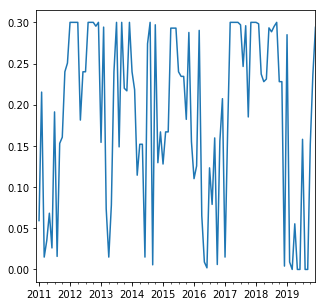

In [38]:
df_w_append.ACWI.plot(figsize=(5,5))

In [1489]:
df_w_append.round(4).iloc[-1][df_w_append.iloc[-1]>0.00001]

ACWI    0.2304
FVD     0.1657
VIG     0.1478
NOBL    0.0125
DGRO    0.0119
PGX     0.1000
PID     0.0127
DEM     0.0126
DGS     0.1503
IDV     0.1559
Name: 2019-12-31 00:00:00, dtype: float64

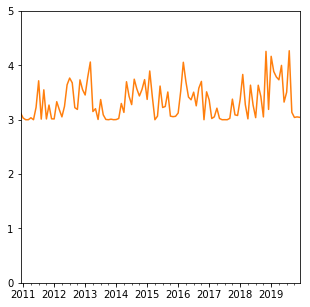

In [39]:
df_result.dvd.plot(color='tab:orange', ylim=(0,5), figsize=(5,5))

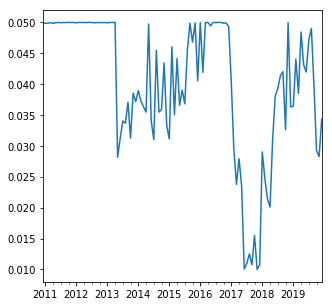

In [40]:
df_result.te.plot(figsize=(5,5))

In [1618]:
perf = np.exp(pd.DataFrame({'HGDM':cum_port2, 'ACWI':cum_bm}))

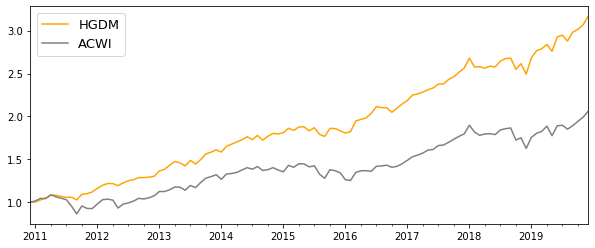

In [1619]:
ax = perf.plot(figsize=(10,4), color=['orange','gray'])
ax.legend(fontsize=13)

In [1620]:
ytd = perf.iloc[-1]/perf.loc['2018-12-31']-1
r3m = perf.iloc[-1]/perf.iloc[-4]-1
r1y = perf.iloc[-1]/perf.iloc[-13]-1
r3y = perf.iloc[-1]/perf.iloc[-37]-1

In [1621]:
pd.DataFrame({'ytd':ytd, '1y':r1y, '3y':r3y})

,ytd,1y,3y
HGDM,0.270204,0.270204,0.476477
ACWI,0.265974,0.265974,0.421700
